# Using the BucketingProcess

The `BucketingProcess` enables a two-step bucketing approach, where a feature is first pre-bucketed to ~100 pre-buckets, and then bucketed. 

This is a common practice - it reduces the complexity of finding exact boundaries to the problem of finding which of 100 buckets to merge together.

In [1]:
%%capture
%load_ext autoreload
%autoreload 2

In [2]:
from skorecard import datasets
from skorecard.bucketers import DecisionTreeBucketer, OptimalBucketer, AsIsCategoricalBucketer
from skorecard.pipeline import BucketingProcess

from sklearn.pipeline import make_pipeline

## Define the BucketingProcess

In the example below, we apply the `BucketingProcess` method to deal with both numerical and categorical variables. In the `prebucketing_pipeline` the numerical variables are bucketed into a maximum of 100 bins.

In [3]:
df = datasets.load_uci_credit_card(as_frame=True)
y = df["default"]
X = df.drop(columns=["default"])

num_cols = ["LIMIT_BAL", "BILL_AMT1"]
cat_cols = ["EDUCATION", "MARRIAGE"]
specials = {"EDUCATION" : {"Is 1": [1] } }

bucketing_process = BucketingProcess(
        prebucketing_pipeline=make_pipeline(
                DecisionTreeBucketer(variables=num_cols, max_n_bins=100, min_bin_size=0.05),
                AsIsCategoricalBucketer(variables=cat_cols)
        ),
        bucketing_pipeline=make_pipeline(
                OptimalBucketer(variables=num_cols, max_n_bins=10, min_bin_size=0.05),
                OptimalBucketer(variables=cat_cols,
                                variables_type='categorical',
                                max_n_bins=10,
                                min_bin_size=0.05),
        ),
        specials=specials
)

## BucketingProcess.fit_transform()

Let us look at the original data, to be compared to the transformed data:

In [4]:
X.head()

,EDUCATION,MARRIAGE,LIMIT_BAL,BILL_AMT1
0,1,2,400000.0,201800.0
1,2,2,80000.0,80610.0
2,1,2,500000.0,499452.0
3,1,1,140000.0,450.0
4,2,1,420000.0,56107.0


As we can see from the following dataframe, the columns have been successfully transformed:

In [5]:
bucketing_process.fit_transform(X, y).head()

,EDUCATION,MARRIAGE,LIMIT_BAL,BILL_AMT1
0,-3,0,8,5
1,1,0,3,4
2,-3,0,8,5
3,-3,1,4,0
4,1,1,8,3


## Methods and Attributes

A `BucketingProcess` instance similar methods & attributes of a bucketer:

- `.summary()`
- `.prebucket_table(column)`
- `.bucket_table(column)`
- `.plot_prebucket(column)`
- `.plot_bucket(column)`
- `.features_bucket_mapping`
- `.save_to_yaml()`

In [6]:
bucketing_process.summary()

,column,num_prebuckets,num_buckets,IV_score,dtype
0,EDUCATION,9,5,0.036308,int64
1,MARRIAGE,6,4,0.013054,int64
2,LIMIT_BAL,14,10,0.168862,float64
3,BILL_AMT1,15,7,0.005823,float64


In [7]:
bucketing_process.prebucket_table("LIMIT_BAL")

,pre-bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV,bucket
0,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000,0
1,0,"[-inf, 25000.0)",479.0,7.98,300.0,179.0,0.373695,-0.725,-0.050,0
2,1,"[25000.0, 45000.0)",370.0,6.17,233.0,137.0,0.370270,-0.710,-0.037,1
3,2,"[45000.0, 55000.0)",676.0,11.27,518.0,158.0,0.233728,-0.054,-0.000,2
4,3,"[55000.0, 75000.0)",336.0,5.60,233.0,103.0,0.306548,-0.425,-0.011,2
5,4,"[75000.0, 85000.0)",319.0,5.32,243.0,76.0,0.238245,-0.079,-0.000,3
6,5,"[85000.0, 105000.0)",330.0,5.50,241.0,89.0,0.269697,-0.245,-0.004,3
7,6,"[105000.0, 145000.0)",566.0,9.43,436.0,130.0,0.229682,-0.031,-0.000,4
8,7,"[145000.0, 175000.0)",449.0,7.48,380.0,69.0,0.153675,0.464,-0.014,5
9,8,"[175000.0, 225000.0)",769.0,12.82,630.0,139.0,0.180754,0.270,-0.009,5


In [8]:
bucketing_process.bucket_table("LIMIT_BAL")

,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
1,0,"[-inf, 1.0)",479.0,7.98,300.0,179.0,0.373695,-0.725,-0.050
2,1,"[1.0, 2.0)",370.0,6.17,233.0,137.0,0.370270,-0.710,-0.037
3,2,"[2.0, 4.0)",1012.0,16.87,751.0,261.0,0.257905,-0.185,-0.006
4,3,"[4.0, 6.0)",649.0,10.82,484.0,165.0,0.254237,-0.165,-0.003
5,4,"[6.0, 7.0)",566.0,9.43,436.0,130.0,0.229682,-0.031,-0.000
6,5,"[7.0, 9.0)",1218.0,20.30,1010.0,208.0,0.170772,0.339,-0.021
7,6,"[9.0, 10.0)",501.0,8.35,419.0,82.0,0.163673,0.390,-0.011
8,7,"[10.0, 12.0)",729.0,12.15,613.0,116.0,0.159122,0.423,-0.019
9,8,"[12.0, inf)",476.0,7.93,409.0,67.0,0.140756,0.567,-0.022


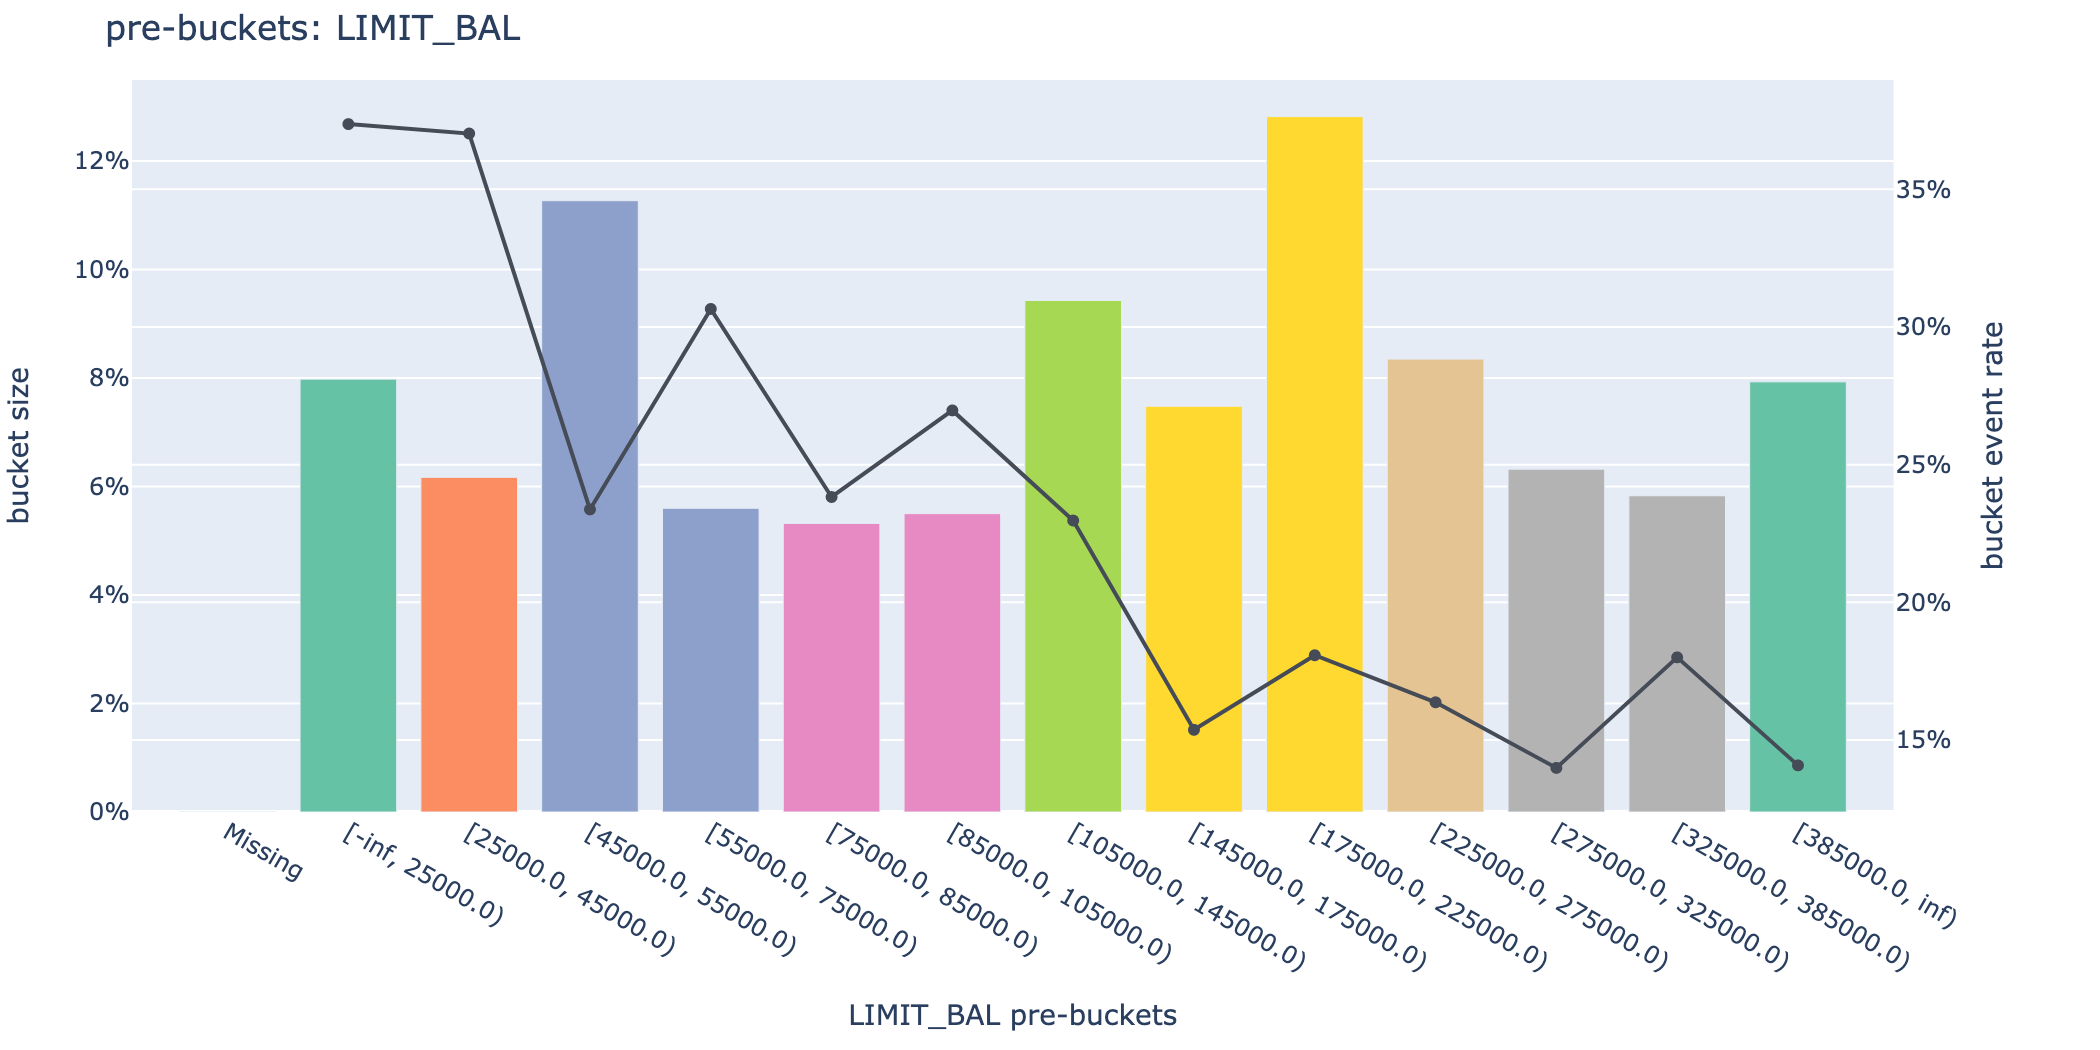

In [9]:
bucketing_process.plot_prebucket("LIMIT_BAL", format="png", scale=2, width=1050, height=525)

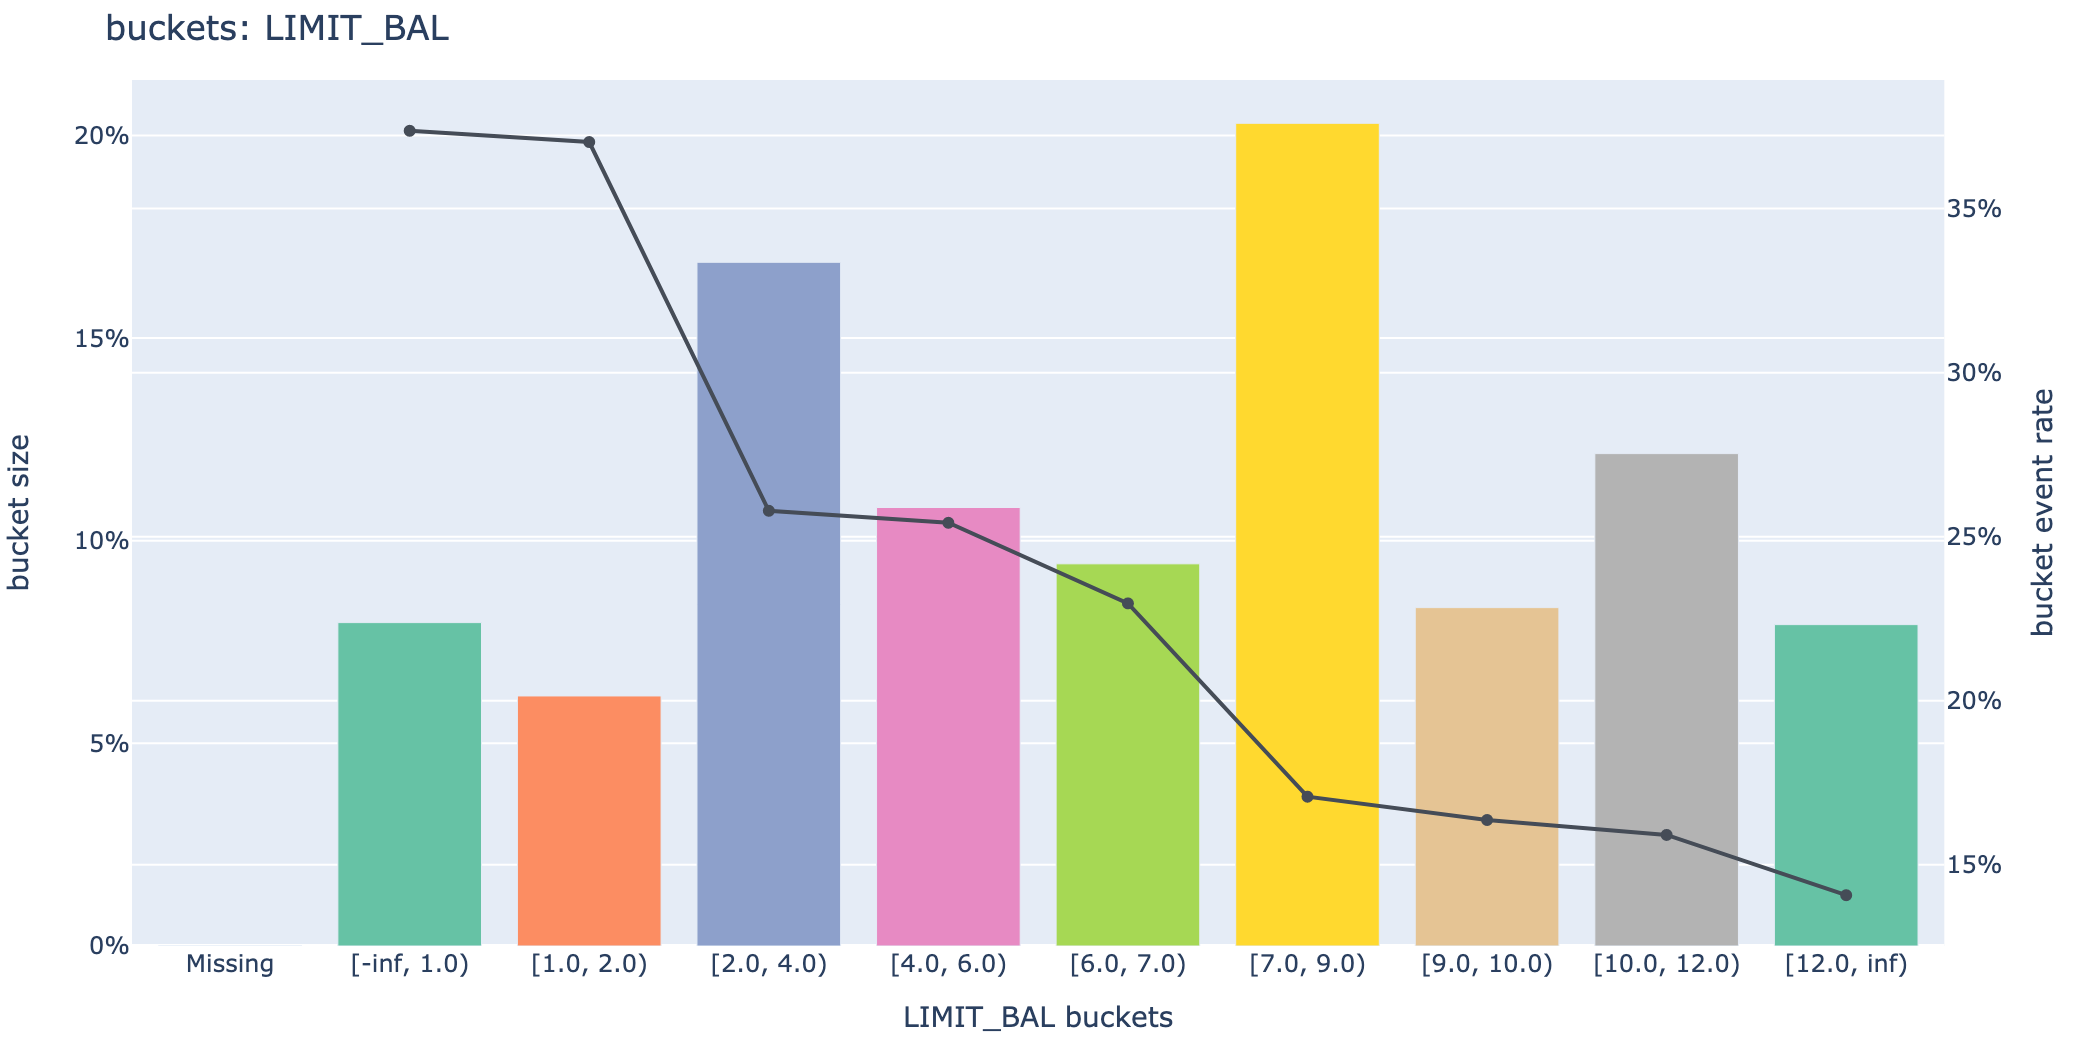

In [10]:
bucketing_process.plot_bucket("LIMIT_BAL", format="png", scale=2, width=1050, height=525)

# The `Skorecard()` class

In [11]:
from skorecard import Skorecard
model = Skorecard(bucketing=bucketing_process)
model.fit(X, y)
model.get_stats()

,Coef.,Std.Err,z,P>|z|
const,-1.240828,0.031693,-39.151596,0.000000e+00
EDUCATION,-0.340250,0.178852,-1.902415,5.711695e-02
MARRIAGE,-1.213080,0.283796,-4.274486,1.915788e-05
LIMIT_BAL,-0.985841,0.080567,-12.236294,1.989084e-34
BILL_AMT1,-0.254500,0.438745,-0.580063,5.618724e-01


In [12]:
model.pipeline

Pipeline(steps=[('bucketer',
                 BucketingProcess(bucketing_pipeline=SkorecardPipeline(steps=[('optimalbucketer-1',
                                                                               OptimalBucketer(specials={'EDUCATION': {'Is 1': [-3]}},
                                                                                               variables=['LIMIT_BAL',
                                                                                                          'BILL_AMT1'])),
                                                                              ('optimalbucketer-2',
                                                                               OptimalBucketer(specials={'EDUCATION': {'Is 1': [-3]}},
                                                                                               variables=['EDUCATION',
                                                                                                          'MARRIAGE'],
                      

In [13]:
model.bucket_table('EDUCATION')

,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-3,Special: Is 1,2186.0,36.43,1789.0,397.0,0.181610,0.264,-0.024
1,-2,Other,0.0,0.00,0.0,0.0,NaN,0.000,0.000
2,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
3,0,"3, 5, 4, 2, 1",1089.0,18.15,829.0,260.0,0.238751,-0.082,-0.001
4,1,0,2725.0,45.42,2037.0,688.0,0.252477,-0.156,-0.012


In [14]:
model.bucketing.features_bucket_mapping_

FeaturesBucketMapping([BucketMapping(feature_name='LIMIT_BAL', type='numerical', missing_bucket=None, other_bucket=None, map=[25000.0, 45000.0, 75000.0, 105000.0, 145000.0, 225000.0, 275000.0, 385000.0], right=False, specials={}), BucketMapping(feature_name='BILL_AMT1', type='numerical', missing_bucket=None, other_bucket=None, map=[833.0, 2559.5, 36140.5, 77964.5, 114883.0], right=False, specials={}), BucketMapping(feature_name='EDUCATION', type='categorical', missing_bucket=None, other_bucket=None, map={2: 1, 3: 0, 5: 0, 6: 0, 4: 0, 0: 0}, right=True, specials={'Is 1': [1]}), BucketMapping(feature_name='MARRIAGE', type='categorical', missing_bucket=None, other_bucket=None, map={2: 0, 1: 1, 3: 1, 0: 0}, right=True, specials={})])